In [5]:
import os
import time
import copy
import math
import pickle
import roadrunner
import numpy as np
import pandas as pd
import pocomc as pc
from scipy.stats import qmc
import matplotlib.pyplot as plt
from multiprocessing import Pool

N_PARTICLES = 1000
SEED=1
np.random.seed(seed=SEED)
n_cpus = os.cpu_count() 

# Model system parameters
MODEL_SBML_FILE = "model2_rxn.xml"
SPECIES = ["x_1", "x_2"]

['k1', 'k2', 'k3', 'k4']


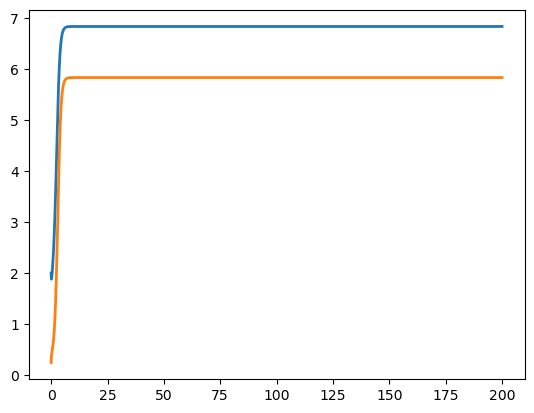

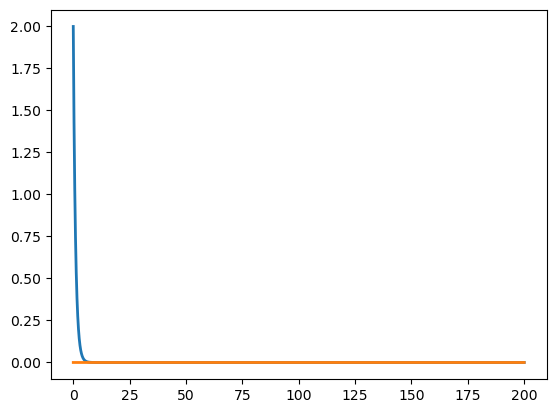

[[<matplotlib.lines.Line2D at 0x7f01d8c7a640>],

In [6]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8
print(rr.model.getGlobalParameterIds())
res = rr.simulate(0, 200, 200*100+1)
rr.plot()
rr.resetAll()
rr["init([x_1])"] = 2
rr["init([x_2])"] = 0
rr.setValue("k1", 0.0)
rr.setValue("k2", 0.0)
rr.setValue("k3", 0.0)
rr.setValue("k4", 1.0)
rr.reset();
res = rr.simulate(0, 200, 200*100+1)
rr.plot()

In [7]:
# Defining Model
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values

    def __call__(self, theta_new):
        theta_new = theta_new
        res = self.log_likelihood(theta_new)
        return res
    
    def run_sim(self, model_param = None, x0=None): #takes in canidate parameters then solves the ode
        if model_param is None:
            model_param = self.theta_true[:self.ODE_params_n]  #sets the model_params to just the model parameters
        if x0 is None:
            x0 = self.x0 #if x0 not defined, default x0 to the model x0
        
        rr.resetAll()
        param_names = rr.model.getGlobalParameterIds()
        sim_n_steps = int(self.ts[-1] * 100 + 1)
        
        t0 = float(self.ts[0]); tstop = float(self.ts[-1])
        for name, val in zip(SPECIES, x0):
            cur_str = "init([%s])"%name
            rr[cur_str] = float(val)
            rr.reset()
            #print(cur_str, val, " rr: ", rr[cur_str])
        for name,val in zip(param_names, model_param):
            rr[name] = float(val)
            rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
            #print(name, val, " rr: ", rr[name])
        try:
            res = rr.simulate(t0, tstop, sim_n_steps)
            t_idxs = np.where(np.in1d(res[:, 0], self.ts))[0]
            result = res[t_idxs, 1:]
        except:
            result = []
        return result
    
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: #if true
            return 0.0 #give 0
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this canidate parameter fitting my data (maximize it)
        model_param = theta_new[:self.ODE_params_n] 
        if self.fit_x0: 
            x0 = theta_new[self.ODE_params_n:(self.ODE_params_n + self.x_n)] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0

        if self.fit_sigma:
            sigma = theta_new[-len(self.observable_index):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observable_index) #makes all sigmas default to 1

        y = self.run_sim(model_param=model_param, x0= x0)
        if not np.any(y):
            return float(-1*1E-15)
        data = self.data #sets data

        # Calculate posterior; how good is parameter in terms of fitting the data
        term1 = -0.5 * np.log(2*np.pi*np.square(sigma))
        term2 = np.square(np.subtract(y, data)) / (2*np.square(sigma))
        logLH = np.sum(term1 - term2)
        return logLH

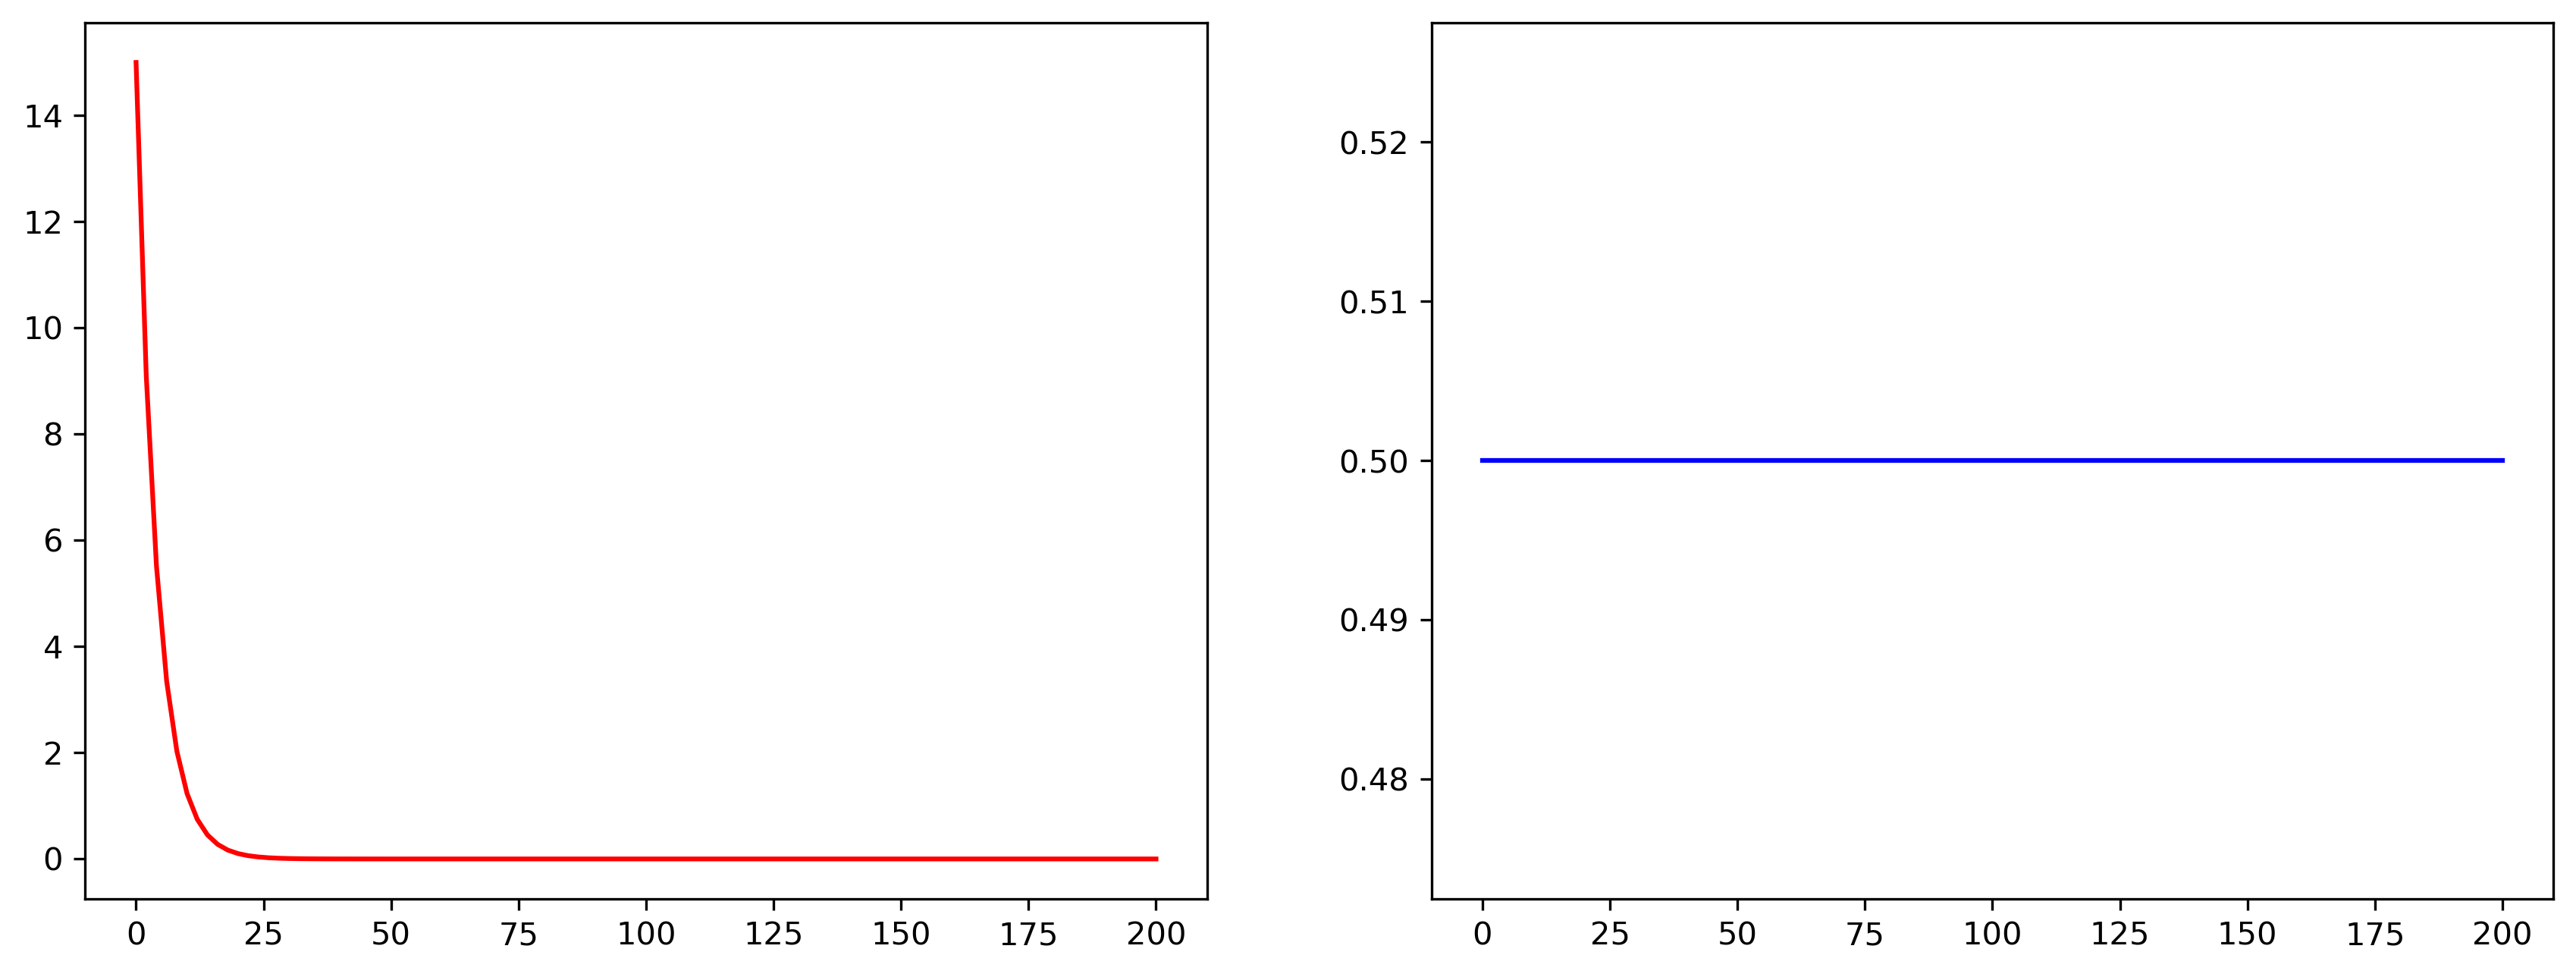

In [8]:
# Creating Model 2 Objects
# Model 2 Options
mod2_opts = {} #creates a dictionary
mod2_opts['theta_n'] = 8 #total number of values in big array
mod2_opts['ODE_params_n'] = 4 # num ODE params
mod2_opts['x_n'] = 2 # num species
mod2_opts['sigma_n'] = 2 # num sigmas
mod2_opts['theta_names'] = ['$k_1$', '$k_2$', '$k_3$', '$k_4$', '$x_1$', '$x_2$','$\sigma_1$','$\sigma_2$'] #names of the parameters (for dictionary)
mod2_opts['fit_x0'] = True # fit initial conditions?
mod2_opts['x0'] = [2, 0.25] # initial conditions (if given)
mod2_opts['fit_sigma'] = True #fit sigma?
mod2_opts['observable_index'] = [0, 1]
mod2_opts['theta_true'] = [8, 1, 1, 1, 2, 0.25, 0.3, 0.3] # true param values
mod2_opts['lower_bnds'] = [2, 0, 0, 0, -3, -3, 1E-3, 1E-3] #lower bounds
mod2_opts['upper_bnds'] = [20, 5, 5, 5, 3, 3, 1, 1] #upper bounds

# load data for model 2
mod2_df = pd.read_csv('m2_data.csv', header=0, delimiter=",") #reads in data file
mod2_opts['ts'] = mod2_df['t'].values #sets data under 't' in csv as 'ts'
mod2_opts['data'] = mod2_df[['x1', 'x2']].values #makes data array and reshapes it
mod2 = Model(mod2_opts)

result = mod2.run_sim([0,0,0,0.25], [15,.5]) #run the simulation on model 2 parameters

fig = plt.figure(figsize=(14,5), dpi=300)
fig.add_subplot(1, 2, 1)
plt.plot(mod2.ts, result[:, 0], 'r-')
#plt.plot(mod2.ts, mod2.data[:, 0], 'ro')

fig.add_subplot(1, 2, 2)
plt.plot(mod2.ts, result[:, 1], 'b-')
#plt.plot(mod2.ts, mod2.data[:, 1], 'bo');


In [9]:
# Latin Hypercube Sampling
n_particles = 1000 #amount of points in the latin hypercube sampling?

# Initialise particles' positions using samples from the prior (this is very important, other initialisation will not work).
sampler = qmc.LatinHypercube(d=mod2.theta_n, seed=SEED) #d is amount of parameters being solved for in model 2
sample = sampler.random(n=n_particles) #causes sample to be an array of n_particles x mod2.theta_n (1000x3)  
prior_samples = qmc.scale(sample, l_bounds=mod2.lower_bnds, u_bounds=mod2.upper_bnds) #widens/narrows sample to be within the bounds given
# Pocomc
t0 = time.time() #stores current time, date, year, etc. in one float
with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    
    sampler = pc.Sampler(n_particles = n_particles,
                    n_dim = mod2.theta_n,
                    log_likelihood = mod2.log_likelihood,
                    log_prior = mod2.log_prior,
                    bounds = np.array(list(zip(mod2.lower_bnds, mod2.upper_bnds))),
                    random_state=SEED,
                    vectorize_likelihood=False,
                    vectorize_prior=False,
                    infer_vectorization=False
                    ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

    sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
    result = sampler.results #results of sampler.run on prior_samples

with open('mod2_result_moccasin.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

#with open('mod2_obj.pkl', 'wb') as f: #open that file if exists, if not make that file
#    pickle.dump(mod2.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model 2 dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run

Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.0998134 and h = 4.64251e-154, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.830774 and h = 2.91517e-154, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.103397 and h = 4.65283e-154, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.105064 and h = 3.73003e-154, the corrector convergence test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.162367 and h = 6.68539e-154, the corrector convergence test failed repeatedly or with |h| = hmin.
Iter: 1it [00:00, 330.42it/s, beta=2.24e-8, calls=1000, ESS=0.95, log


Elapsed time:  00:20:27


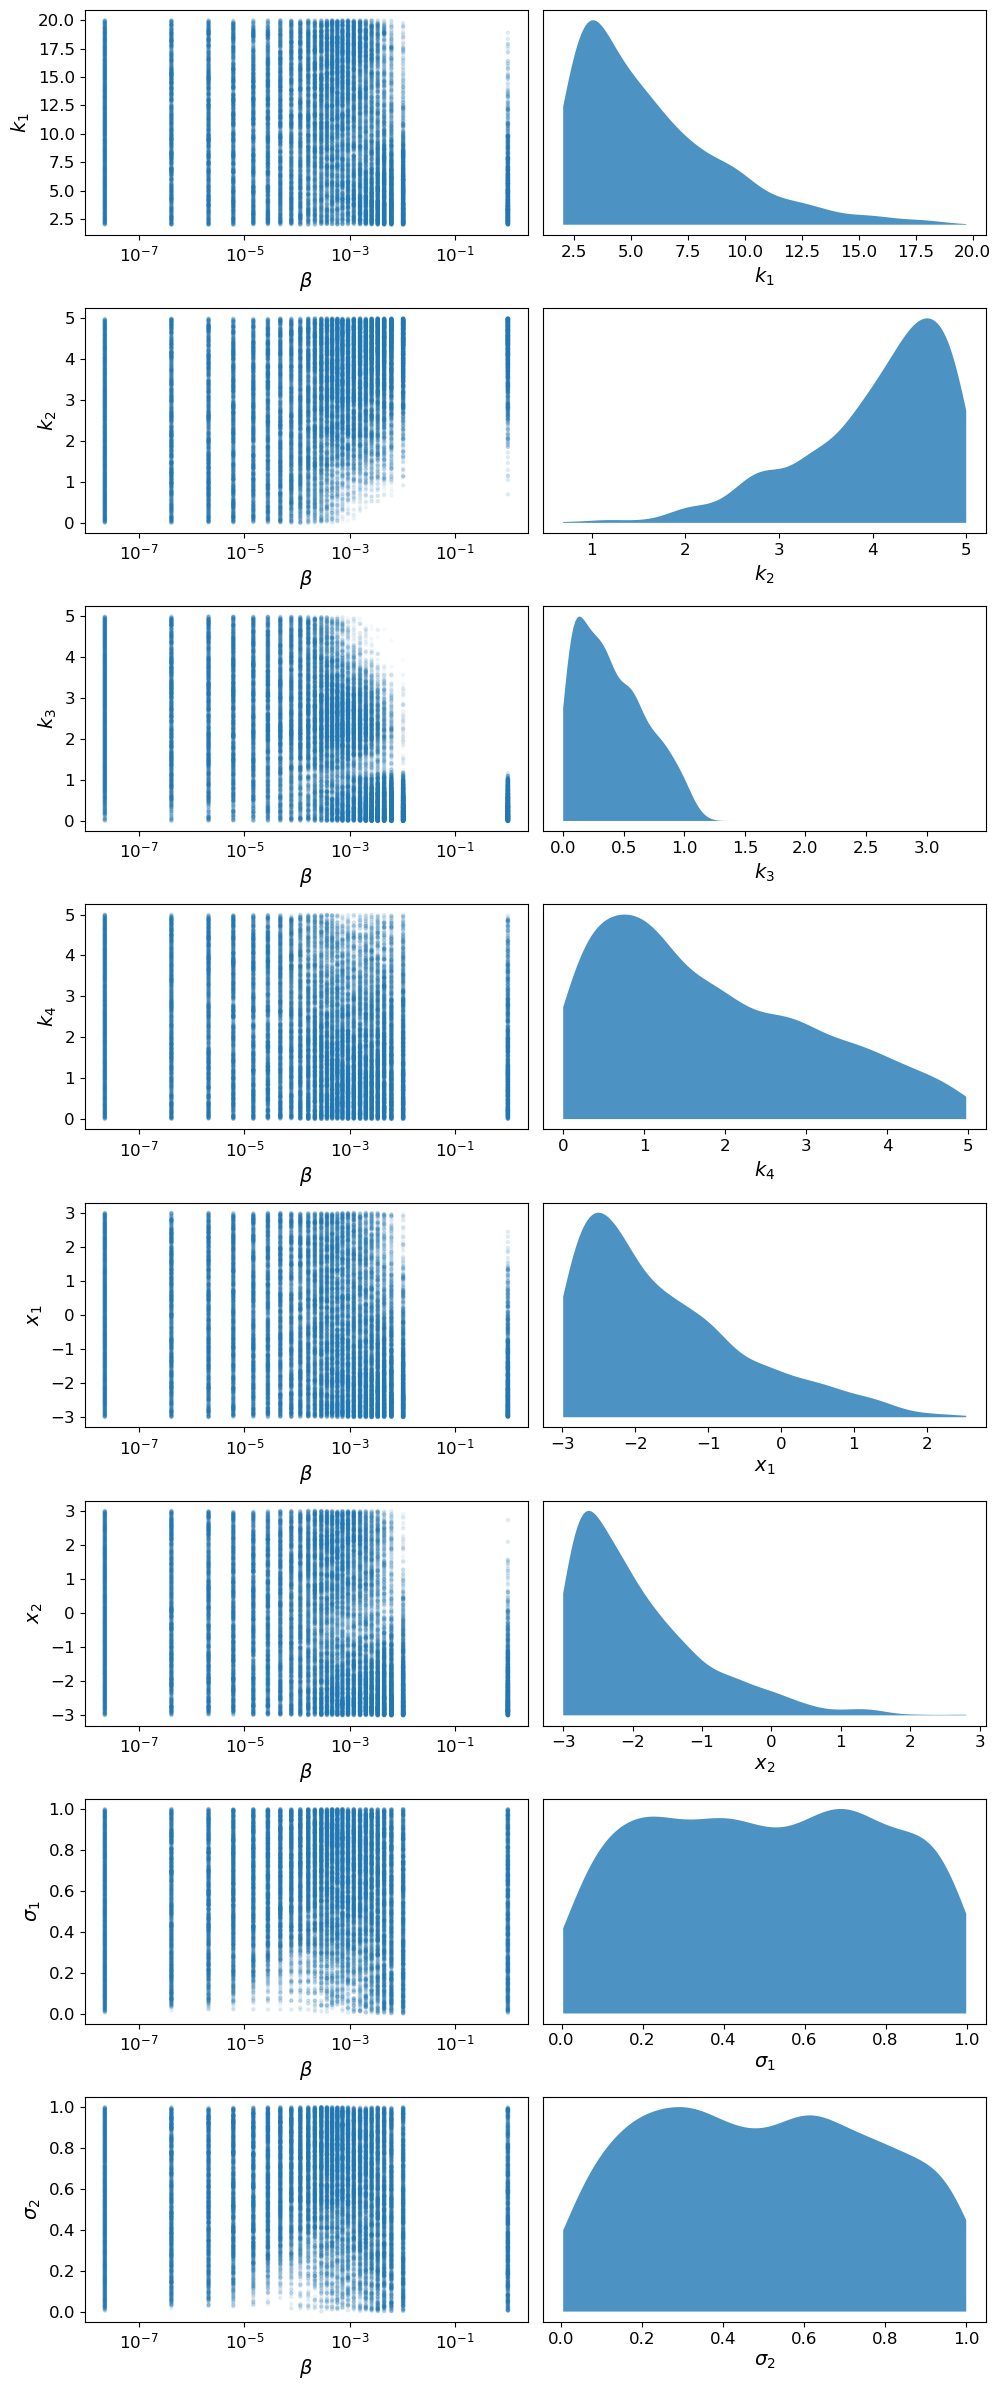

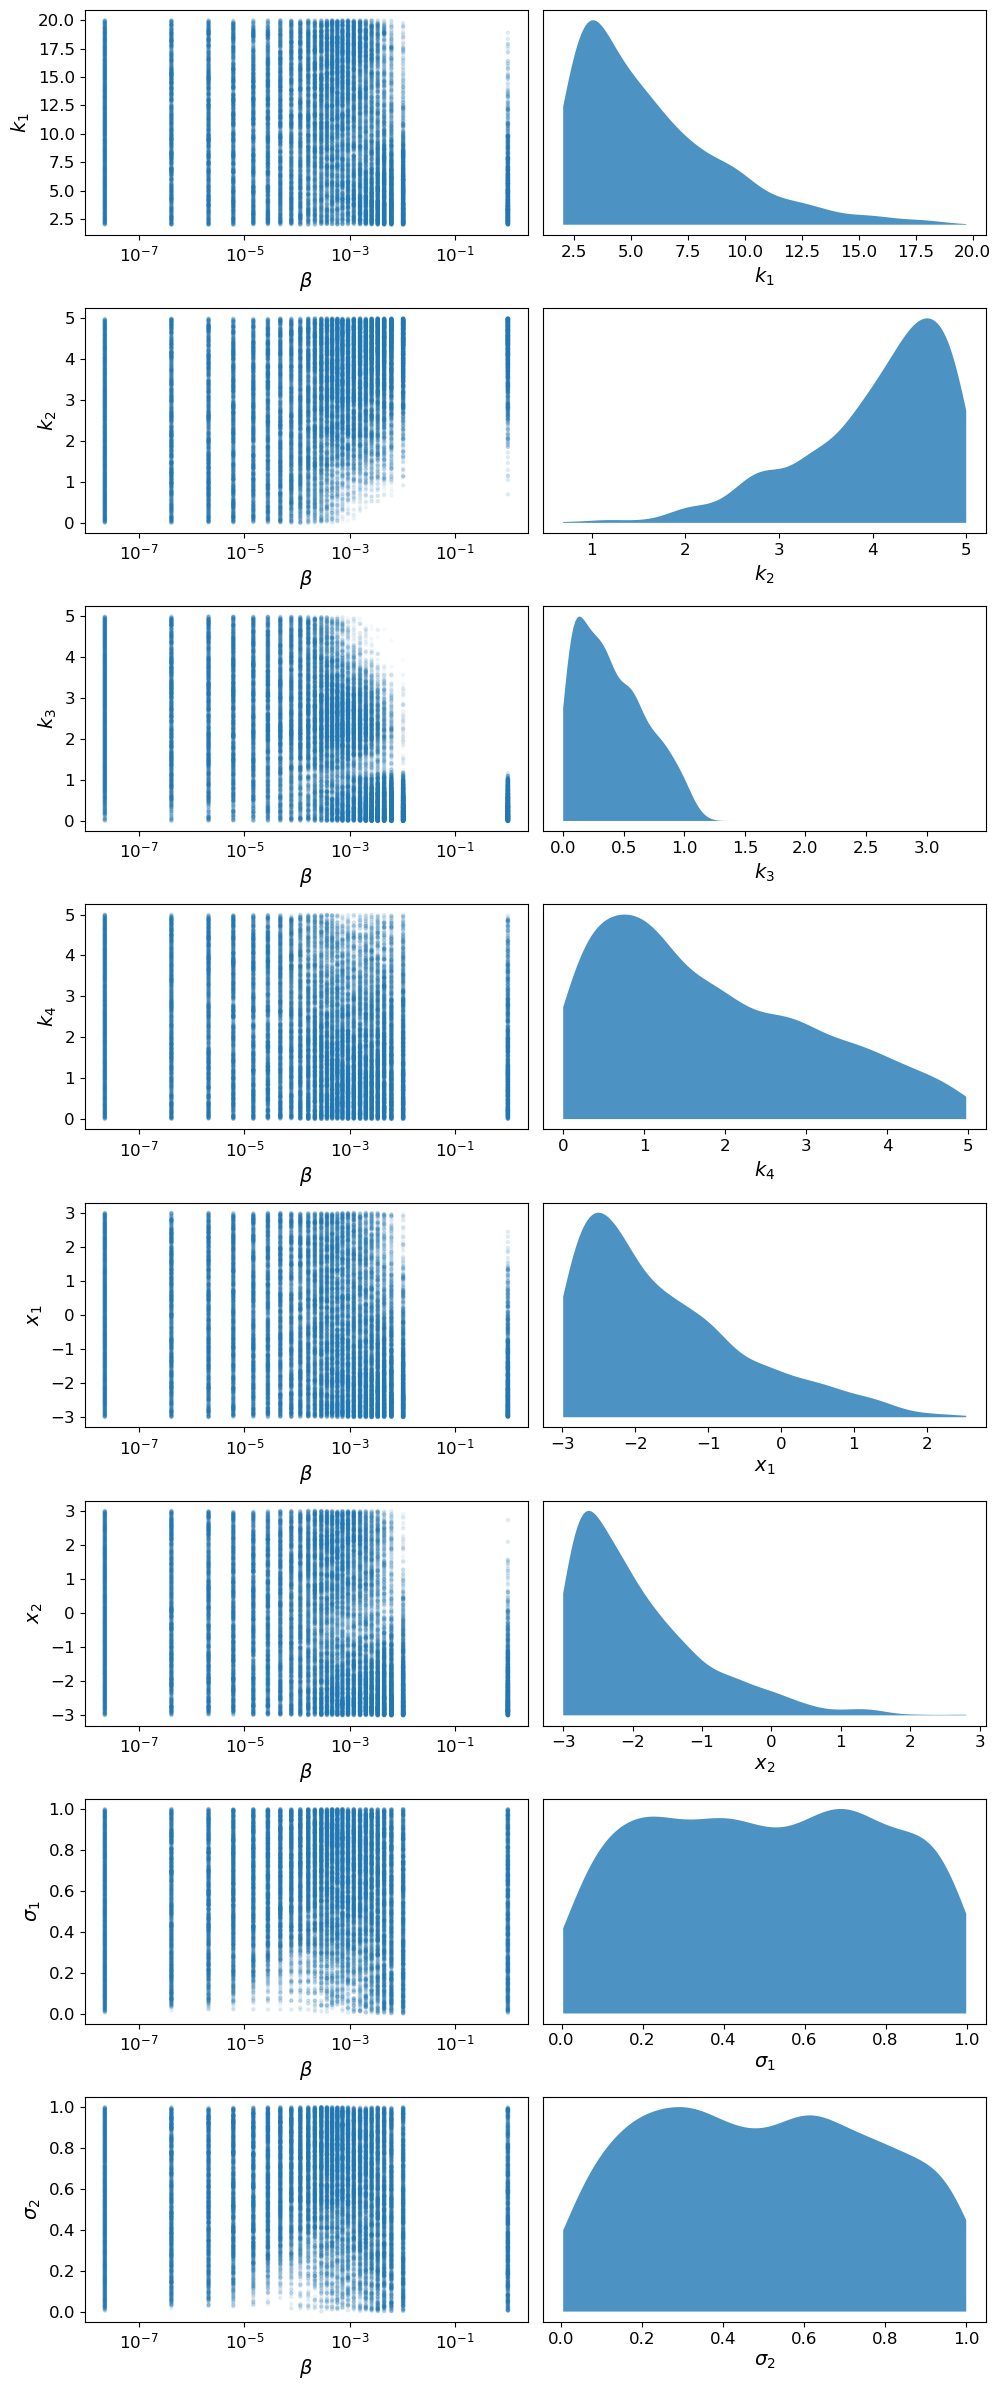

In [10]:
RESULT_FILE = "mod2_result_moccasin.pkl"
with open(RESULT_FILE, "rb") as f:
    results = pickle.load(f)
    
pc.plotting.trace(results, mod2.theta_names)